# Clean dataset using influence functions and neural networks

This notebook shows how to use influence functions to clean a dataset from noisy or anomalous data-points. In particular:

- it shows how to calculate influences using pyDVL for an arbitrary dataset of data samples $X_\text{train} \subseteq \mathbb{R}^d$ given a test set $X_\text{test} \subseteq \mathbb{R}^d$.
- it then shows that choosing a training subsets among the highest-influence points can achieve the same accuracy with much less training steps.

In this example we will use the wine dataset from sklearn.

In [1]:
from sklearn.datasets import load_wine
from valuation.utils.dataset import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

wine_bunch = load_wine(as_frame=True)
x, x_test, y, y_test = train_test_split(
            wine_bunch.data, wine_bunch.target, train_size=0.5,
        )
x_train, x_val, y_train, y_val = train_test_split(
            x, y, train_size=0.8,
        )
# print(y_train[:90].values)
# y_train[:90] = [(value +1)%3 for value in y_train[:90]]
# print(y_train[:90].values)

Let's now import all the most important methods

In [2]:
from copy import copy
import torch
from valuation.influence.model_wrappers import TorchNeuralNetwork, fit_torch_model
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.optim import Adam, lr_scheduler
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

## Fit a neural network to the data

First, let's create a 2-layer neural network. PyDVL has some convenience wrappers to initialize a pytorch NN. If you already have a model loaded and trained, you can skip this section.

In [3]:
x_transformer = MinMaxScaler()

transformed_x_train = x_transformer.fit_transform(x_train)
transformed_x_test = x_transformer.transform(x_test)

transformed_x_train = torch.tensor(transformed_x_train, dtype=torch.float)
transformed_y_train = torch.tensor(y_train.to_numpy(), dtype=torch.long)

transformed_x_test = torch.tensor(transformed_x_test, dtype=torch.float)
transformed_y_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

transformed_x_val = x_transformer.transform(x_val)
transformed_x_val = torch.tensor(transformed_x_val, dtype=torch.float)
transformed_y_val = torch.tensor(y_val.to_numpy(), dtype=torch.long)

feature_dimension = x_train.shape[1]
unique_classes = np.unique(np.concatenate((y_train, y_test)))
num_classes = len(unique_classes)
network_size = [16, 16]

num_epochs = 1000
lr = 0.001
weight_decay=0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nn = TorchNeuralNetwork(feature_dimension, num_classes, network_size)
nn.to(device)
optimizer = Adam(params=nn.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_loss, val_loss = fit_torch_model(
    model=nn,
    x_train=transformed_x_train,
    y_train=transformed_y_train,
    x_val = transformed_x_val,
    y_val = transformed_y_val,
    loss=F.cross_entropy,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    batch_size=16,
)

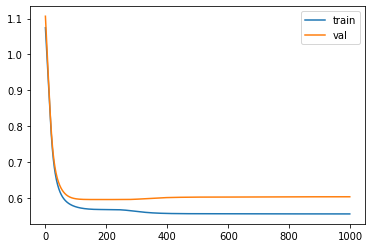

In [4]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

A short visual inspection yields that all labels of the test set are now classified correctly. This can be verified with the following

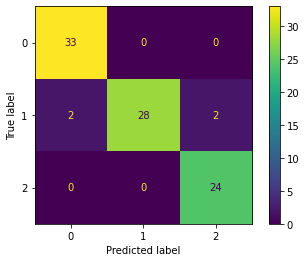

In [5]:
pred_y_test = np.argmax(nn(transformed_x_test).detach(), axis=1)

cm = confusion_matrix(transformed_y_test, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Let's also look at the f1 score

In [6]:
f1_score(transformed_y_test, pred_y_test, average="weighted")

0.9543379599030624

Let's now move to calculating influences of each point on the total score.

## Calculating influences for small neural networks

The following cell calculates the influences of each training data-point on the neural network error. 
The calculation of the Hessian matrix (necessary to calculate the influences) can be quite numerically challenging, but there are some techniques to speed up the calculation. PyDVL allows to use the full method ("direct") or the conjugate gradient method ("cg"). The first one should be used only for very small networks (like our current example), while for bigger ones "cg" is advisable.

In [7]:
from valuation.influence.general import influences

inversion_method = "direct" # cg for big networks

train_influences = influences(nn, F.cross_entropy, 
                              transformed_x_train, transformed_y_train, transformed_x_test, transformed_y_test,
                              inversion_method=inversion_method, influence_type ="up",)

Let's now inspect the data type and values returned by the influences method

In [8]:
train_influences.shape

(89, 71)

We have a numpy array with one row per test data-point, and one column per train data-point. Each value of the matrix, $a_{i,j}$, represents the influence of the $j$-th training data-point on the $i$-th test data-point. If we take the average across every column, we obtain an estimate of the overall influence of a training point on the total accuracy of the network.

In [9]:
mean_train_influences = np.mean(train_influences, axis=(0))

How are these influences distributed across points? Are all points as influential? The following histogram shows that there are big differences in score within the training set (notice the log-scale on the y axis).

Text(0, 0.5, 'number of points')

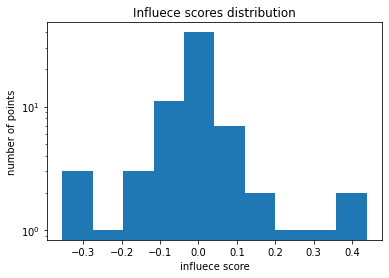

In [10]:
plt.hist(mean_train_influences, log=True)
plt.title('Influece scores distribution')
plt.xlabel('influece score')
plt.ylabel('number of points')

It seems to be that very few points have a disproportionate impact on model performance, while the bulk of the training set can be essentially ignored: they have 0 influence score!

## Keeping the most influential samples

Let's now compare the training times and performance of two subsets of our training set, one where the points are chosen at random, and one only keeping the highest influence points. Let's start with the random subset

In [11]:
random_idxs = np.random.permutation(list(range(len(x_train))))[:20]
random_subset_x_train = transformed_x_train[random_idxs]
random_subset_y_train = transformed_y_train[random_idxs]

f1_scores = []

for _ in range(10):
    nn_random_ds = TorchNeuralNetwork(feature_dimension, num_classes, network_size)
    nn_random_ds.to(device)
    optimizer = Adam(params=nn_random_ds.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    train_loss_random, val_loss_random = fit_torch_model(
        model=nn_random_ds,
        x_train=random_subset_x_train,
        y_train=random_subset_y_train,
        x_val = transformed_x_val,
        y_val = transformed_y_val,
        loss=F.cross_entropy,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=num_epochs,
        batch_size=16,
    )

    pred_y_test_random_ds = np.argmax(nn_random_ds(transformed_x_test).detach(), axis=1)
    f1_scores.append(f1_score(transformed_y_test, pred_y_test_random_ds, average="weighted"))
np.mean(f1_scores)

0.9569490699536234

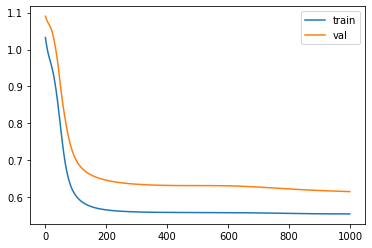

In [12]:
plt.plot(train_loss_random, label='train')
plt.plot(val_loss_random, label='val')
plt.legend()
plt.show()

and now let's take the top influence function data-points

In [13]:
top_influece_idxs = np.argsort(mean_train_influences)[:20]
top_influence_x_train = transformed_x_train[top_influece_idxs]
top_influence_y_train = transformed_y_train[top_influece_idxs]

f1_scores = []

for _ in range(10):
    nn_top_influences_ds = TorchNeuralNetwork(feature_dimension, num_classes, network_size)
    nn_top_influences_ds.to(device)
    optimizer = Adam(params=nn_top_influences_ds.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    train_loss_top_if, val_loss_top_if = fit_torch_model(
        model=nn_top_influences_ds,
        x_train=top_influence_x_train,
        y_train=top_influence_y_train,
        x_val = transformed_x_val,
        y_val = transformed_y_val,
        loss=F.cross_entropy,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=num_epochs,
        batch_size=16,
    )

    pred_y_test_top_influences_ds = np.argmax(nn_top_influences_ds(transformed_x_test).detach(), axis=1)
    f1_scores.append(f1_score(transformed_y_test, pred_y_test_top_influences_ds, average="weighted"))
np.mean(f1_scores)

0.9820219395265513

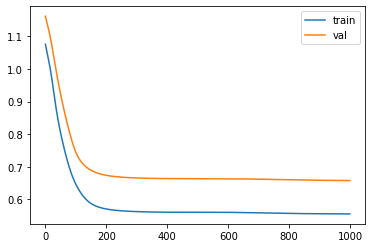

In [14]:
plt.plot(train_loss_top_if, label='train')
plt.plot(val_loss_top_if, label='val')
plt.legend()
plt.show()

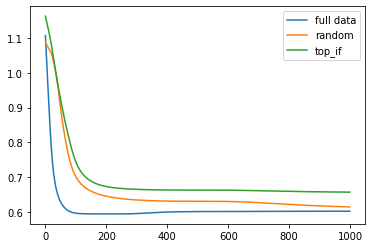

In [15]:
plt.plot(val_loss, label='full data')
plt.plot(val_loss_random, label='random')
plt.plot(val_loss_top_if, label='top_if')
plt.legend()
plt.show()